Importation des bibliotheques necessaire: 

In [1]:
import random
import json
import pickle
import nltk
from nltk.stem import WordNetLemmatizer
from keras.models import load_model
import numpy as np
from abc import ABC
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import requests
from googletrans import Translator

from textblob import TextBlob

In [2]:
from flask_cors import CORS
from flask_ngrok import run_with_ngrok

Class du chatbot qui contient la fonction process_text() qui fait la lemmatization de l'input , bag_of words() qui transforme l'input en binaire pour qu'elle soit comprise par le chatbot , la fonction predict_intent() qui cherche la classe correspondante a l'input, generate_response() est la fonction qui donne la reponse aleatoire parmis les reponses disponibles , chatbot_response() est la partie ou se fait la traduction 

In [3]:
class Seq2SeqChatbot():
    intentss=None
    vocabulary=None
    classes=None
    model=None
    icon_path=None
    description=None
    def __init__(self,name, intents_path, model_path,vocabulary_path,classes_path,icone_path,description):
        self.description=description
        self.name = name
        self.status = False
        self.icon_path=icone_path
        self.intentss = json.loads(open(intents_path, encoding='UTF-8').read())
        self.vocabulary = pickle.load(open(vocabulary_path, "rb"))
        self.classes = pickle.load(open(classes_path, "rb"))
        self.model_name = model_path
        # options for language detection models
        self.lang_detect_model = ["googletrans", "fasttext"]
        # initialize Lemmatizer instance
        self.lemmatizer = WordNetLemmatizer()
    def load(self):
        self.model = load_model(self.model_name)
        self.status = True
        return True  



    # preprocess user input text
    def prepocess_text(self,text):
    # tokenize the text
        words = nltk.word_tokenize(text)
    # lemmatize each word
        words = [self.lemmatizer.lemmatize(word.lower()) for word in words]
        return words


# return bag of words array: 0 or 1 for each word in vocab present in sentence
    def bag_of_words(self,text, vocab, show_details=True):
    # preprocess text
        sentence_words = self.prepocess_text(text)
    # bag of words - vocabulary matrix - matrix of N words
        bag = [0] * len(vocab)
        for s in sentence_words:
            for i, w in enumerate(vocab):
                if w == s:
                # assign 1 if the word is in vocabulary
                    bag[i] = 1
                    if show_details:
                        print("found in bag: %s" % w)
        return np.array(bag)


# predict corresponding intent for input text
    def predict_intent(self,sentence, model):
        print("hello")
        p = self.bag_of_words(sentence, self.vocabulary, show_details=False)
        # filter out predictions by threshold
        res = model.predict(np.array([p]))[0]
        ERROR_THRESHOLD = 0.25
        results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
        # sort by probability score
        results.sort(key=lambda x: x[1], reverse=True)
        return_list = []
        for r in results:
            return_list.append({"intent": self.classes[r[0]], "probability": str(r[1])})
        
        return return_list


# generate output response based on identified intent of input
    def generate_response(self,ints, intents_json):
        tag = ints[0]["intent"]
        result="Sorry , we don't have this information , ask another question please ."
        list_of_intents = intents_json["intents"]
        for i in list_of_intents:
            if i["tag"] == tag:
            # select a response at random from available responses
                result = random.choice(i["responses"])
                break
        return result


# generate chatbot output for user input message
    def chatbot_response(self,msg):
        msgg=TextBlob(msg)
        lang=msgg.detect_language()
        if(lang!="en"):
            msg=str(msgg.translate(to="en"))
        ints = self.predict_intent(msg, self.model)
        res = self.generate_response(ints, self.intentss)
        if(lang!="en"):
            res=TextBlob(res)
            res=res.translate(to=lang)
        return str(res)
    def get_status(self):
        return self.status
    

La classe de la gestion est ou on charge les models avec load_bot(), on recupere la reponse du get_answer() en precisont le theme du chatbot avec le champ name , et on retourne la balise lbot qui contient une liste des dictionnaire avec les icones de chaque chatbot .

In [4]:
class Gestion:
    DataBase = 'Chatbots.json'
    bots_objects = {}

    def __init__(self):
        with open(self.DataBase, 'r') as myfile:
            data=myfile.read()
        bots = json.loads(data)["chatbots"]
        for bot in bots:
            self.bots_objects[bot["intitule"]] = Seq2SeqChatbot(bot["intitule"],bot["json"],bot["modelName"],bot["vocabulary"],bot["classes"],bot["icone"],bot["description"])
           

                
    def load_bot(self, name):
        if self.bots_objects[name].get_status():
            return True
        else:
            return self.bots_objects[name].load()

    def get_answer(self, name, query):
        if self.bots_objects[name].get_status():
            return self.bots_objects[name].chatbot_response(query)
        else:
            return 'please wait'

    #Creer une liste des chatbots pour l'utilisateur
    def list(self):
        lbot = []
        for key in self.bots_objects:
            
            keys=self.bots_objects[key]
            print(keys.icon_path)
            lbot.append({
                "name": key,
                
                "uri": keys.icon_path,
                "color": "red",
                "description": keys.description
            })
        return lbot

    def add_proposition(self, app, name, question, response):
        file2 = open("MyFile2.txt","a")
        file2.write(question) 
        file2.write("\n")
        file2.write(response) 
        
        
        

FLASK

In [5]:
# Creer l'instance du serveur flask

import json
app = Flask('__main__')
CORS(app)
run_with_ngrok(app)
#Creer l'instance du gestionnaire
gst = Gestion()

la route de la reponse 

In [6]:
@app.route('/ask/<name>', methods=['GET'])
def hello_world(name):
    answer = gst.get_answer(name, request.args.get('query'))
    return jsonify(ans=answer)

route de chargement des  bots

In [7]:
@app.route('/load/<name>', methods=['GET'])
def load_bot(name):
    gst.load_bot(name)
    return jsonify(ans=True)

route ou on envoie les informations de chaque bot et on enregistre les suggestions de l'utilisateur

In [8]:
@app.route('/list', methods=['Get'])
def list_of_bots():
    lbot = gst.list()
    return jsonify(lbot)

@app.route('/propose/<name>', methods=['Post',"GET"])
def propose(name):
    gst.add_proposition(app, name, request.args.get('question'), request.args.get('response'))
    return jsonify(ans=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://9a19243000f4.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [26/Jul/2021 18:53:58] "GET //list HTTP/1.1" 200 -






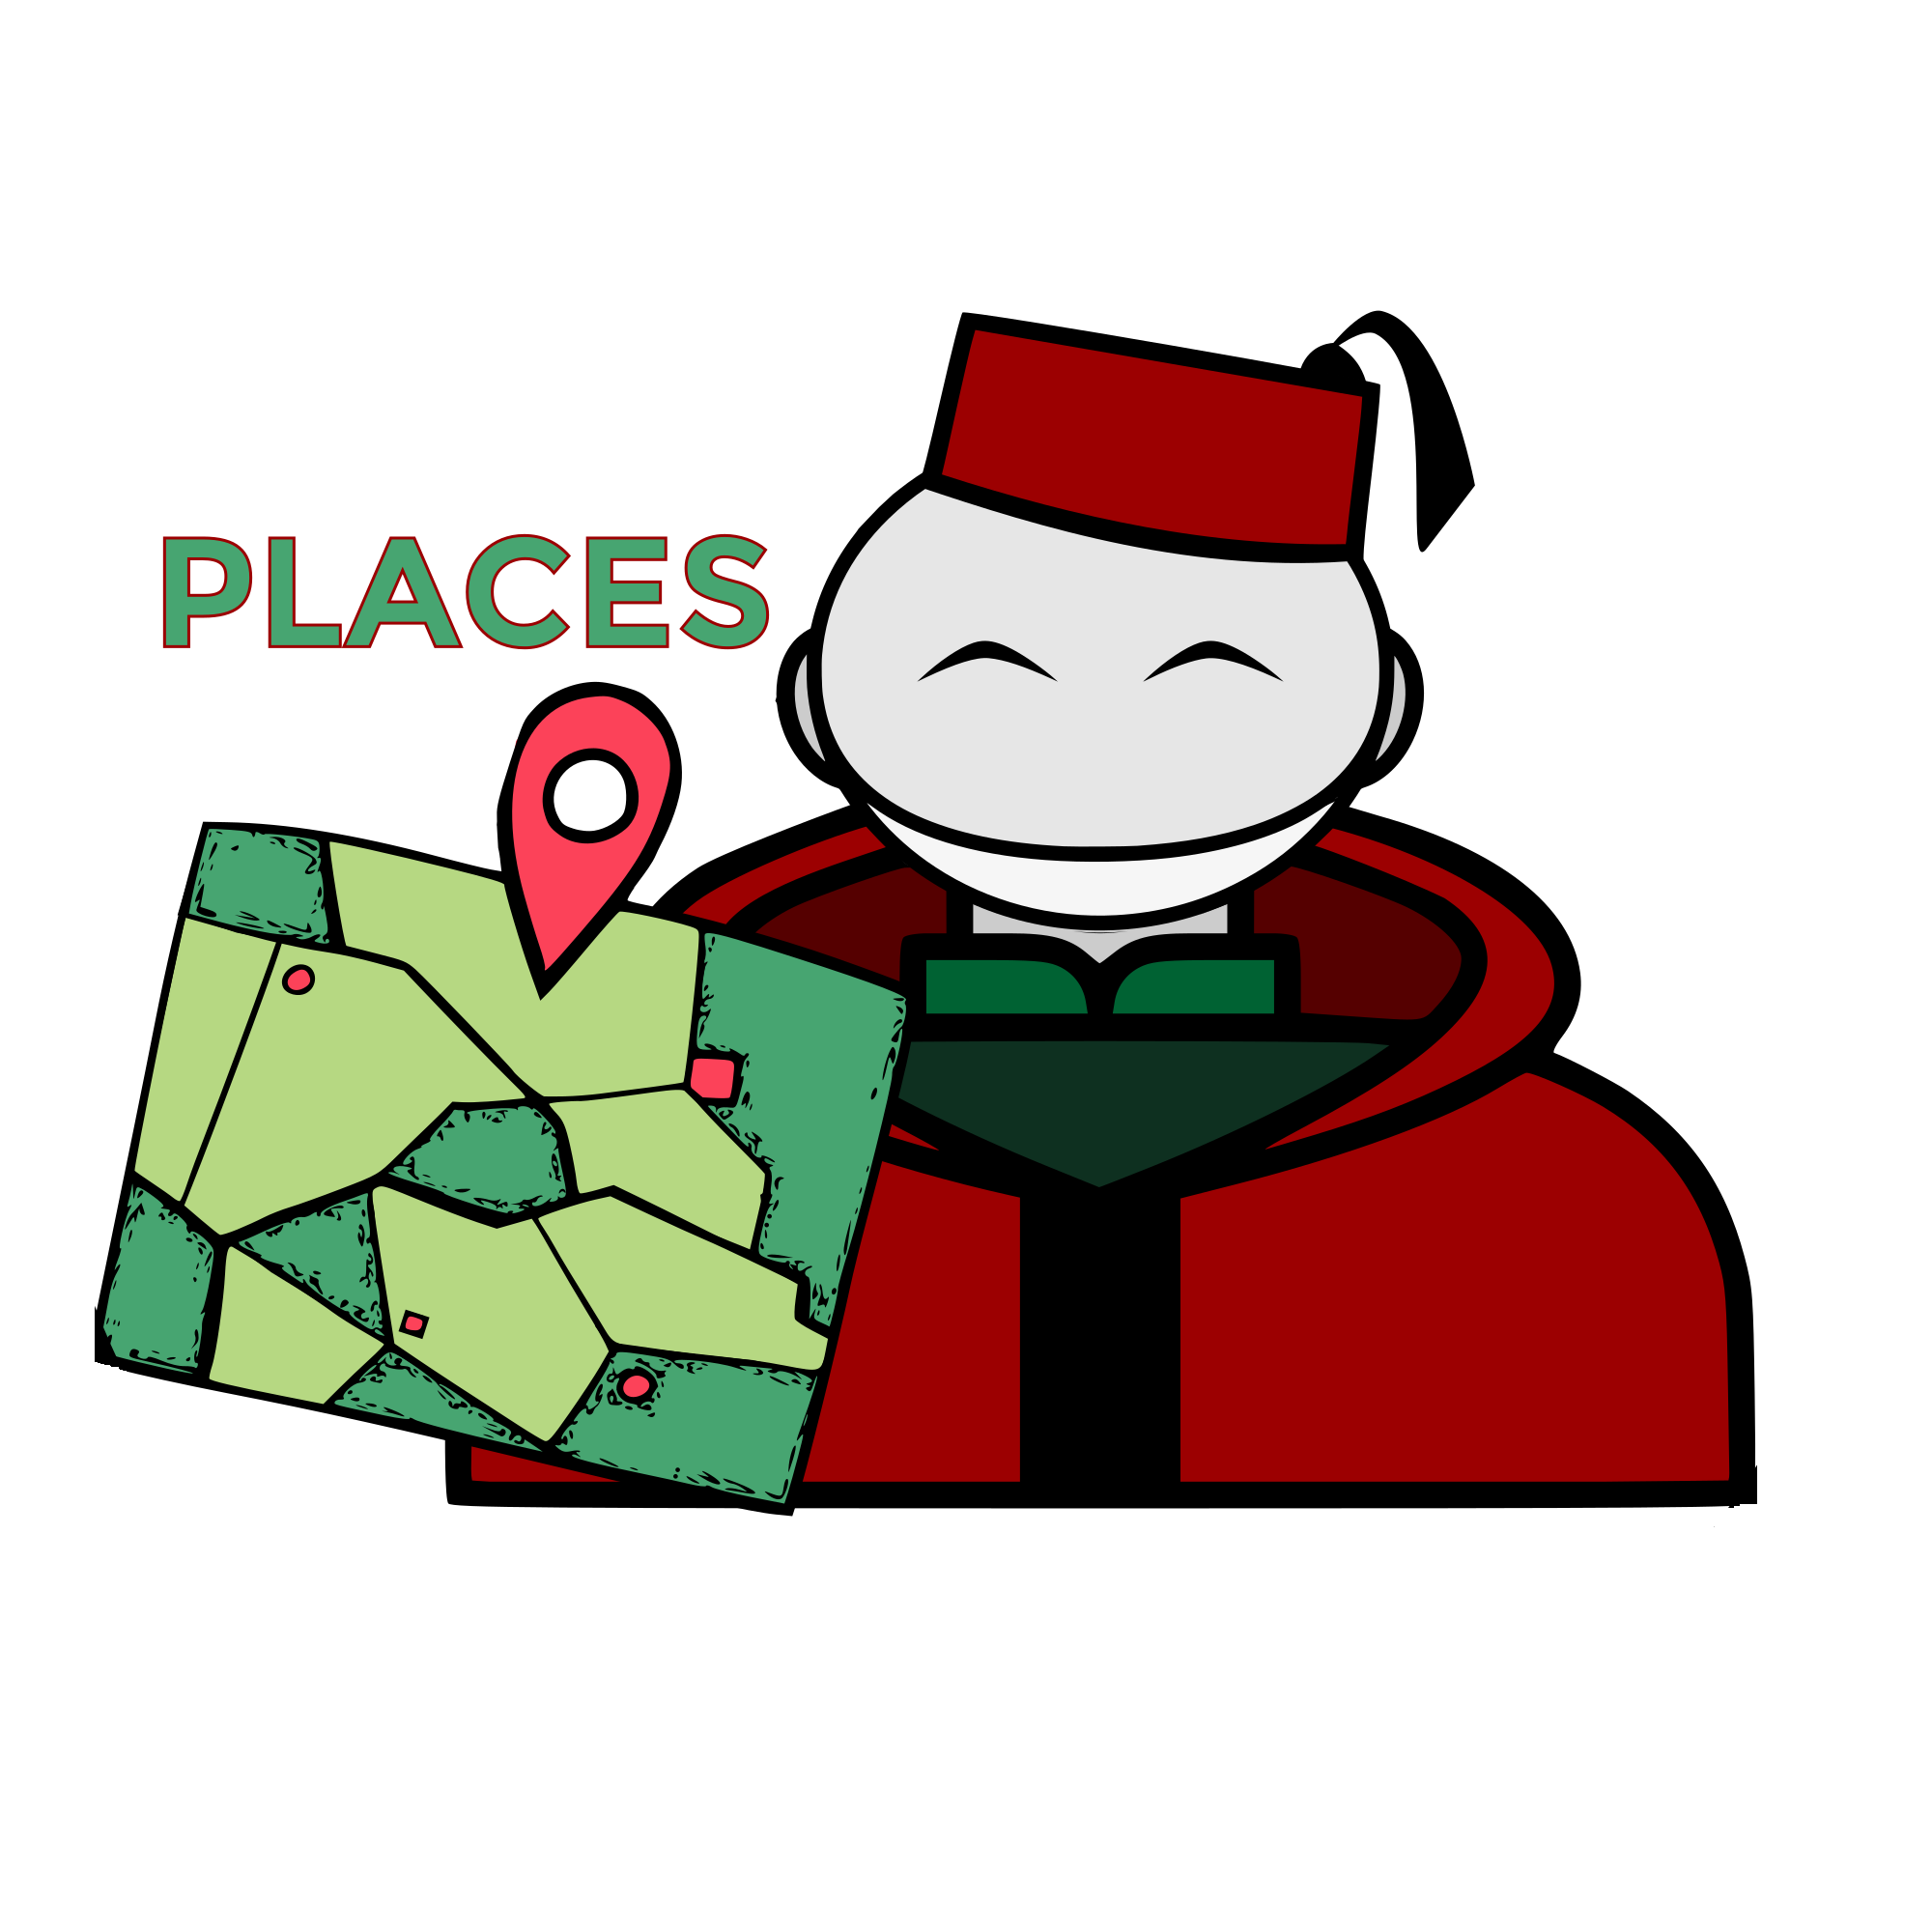
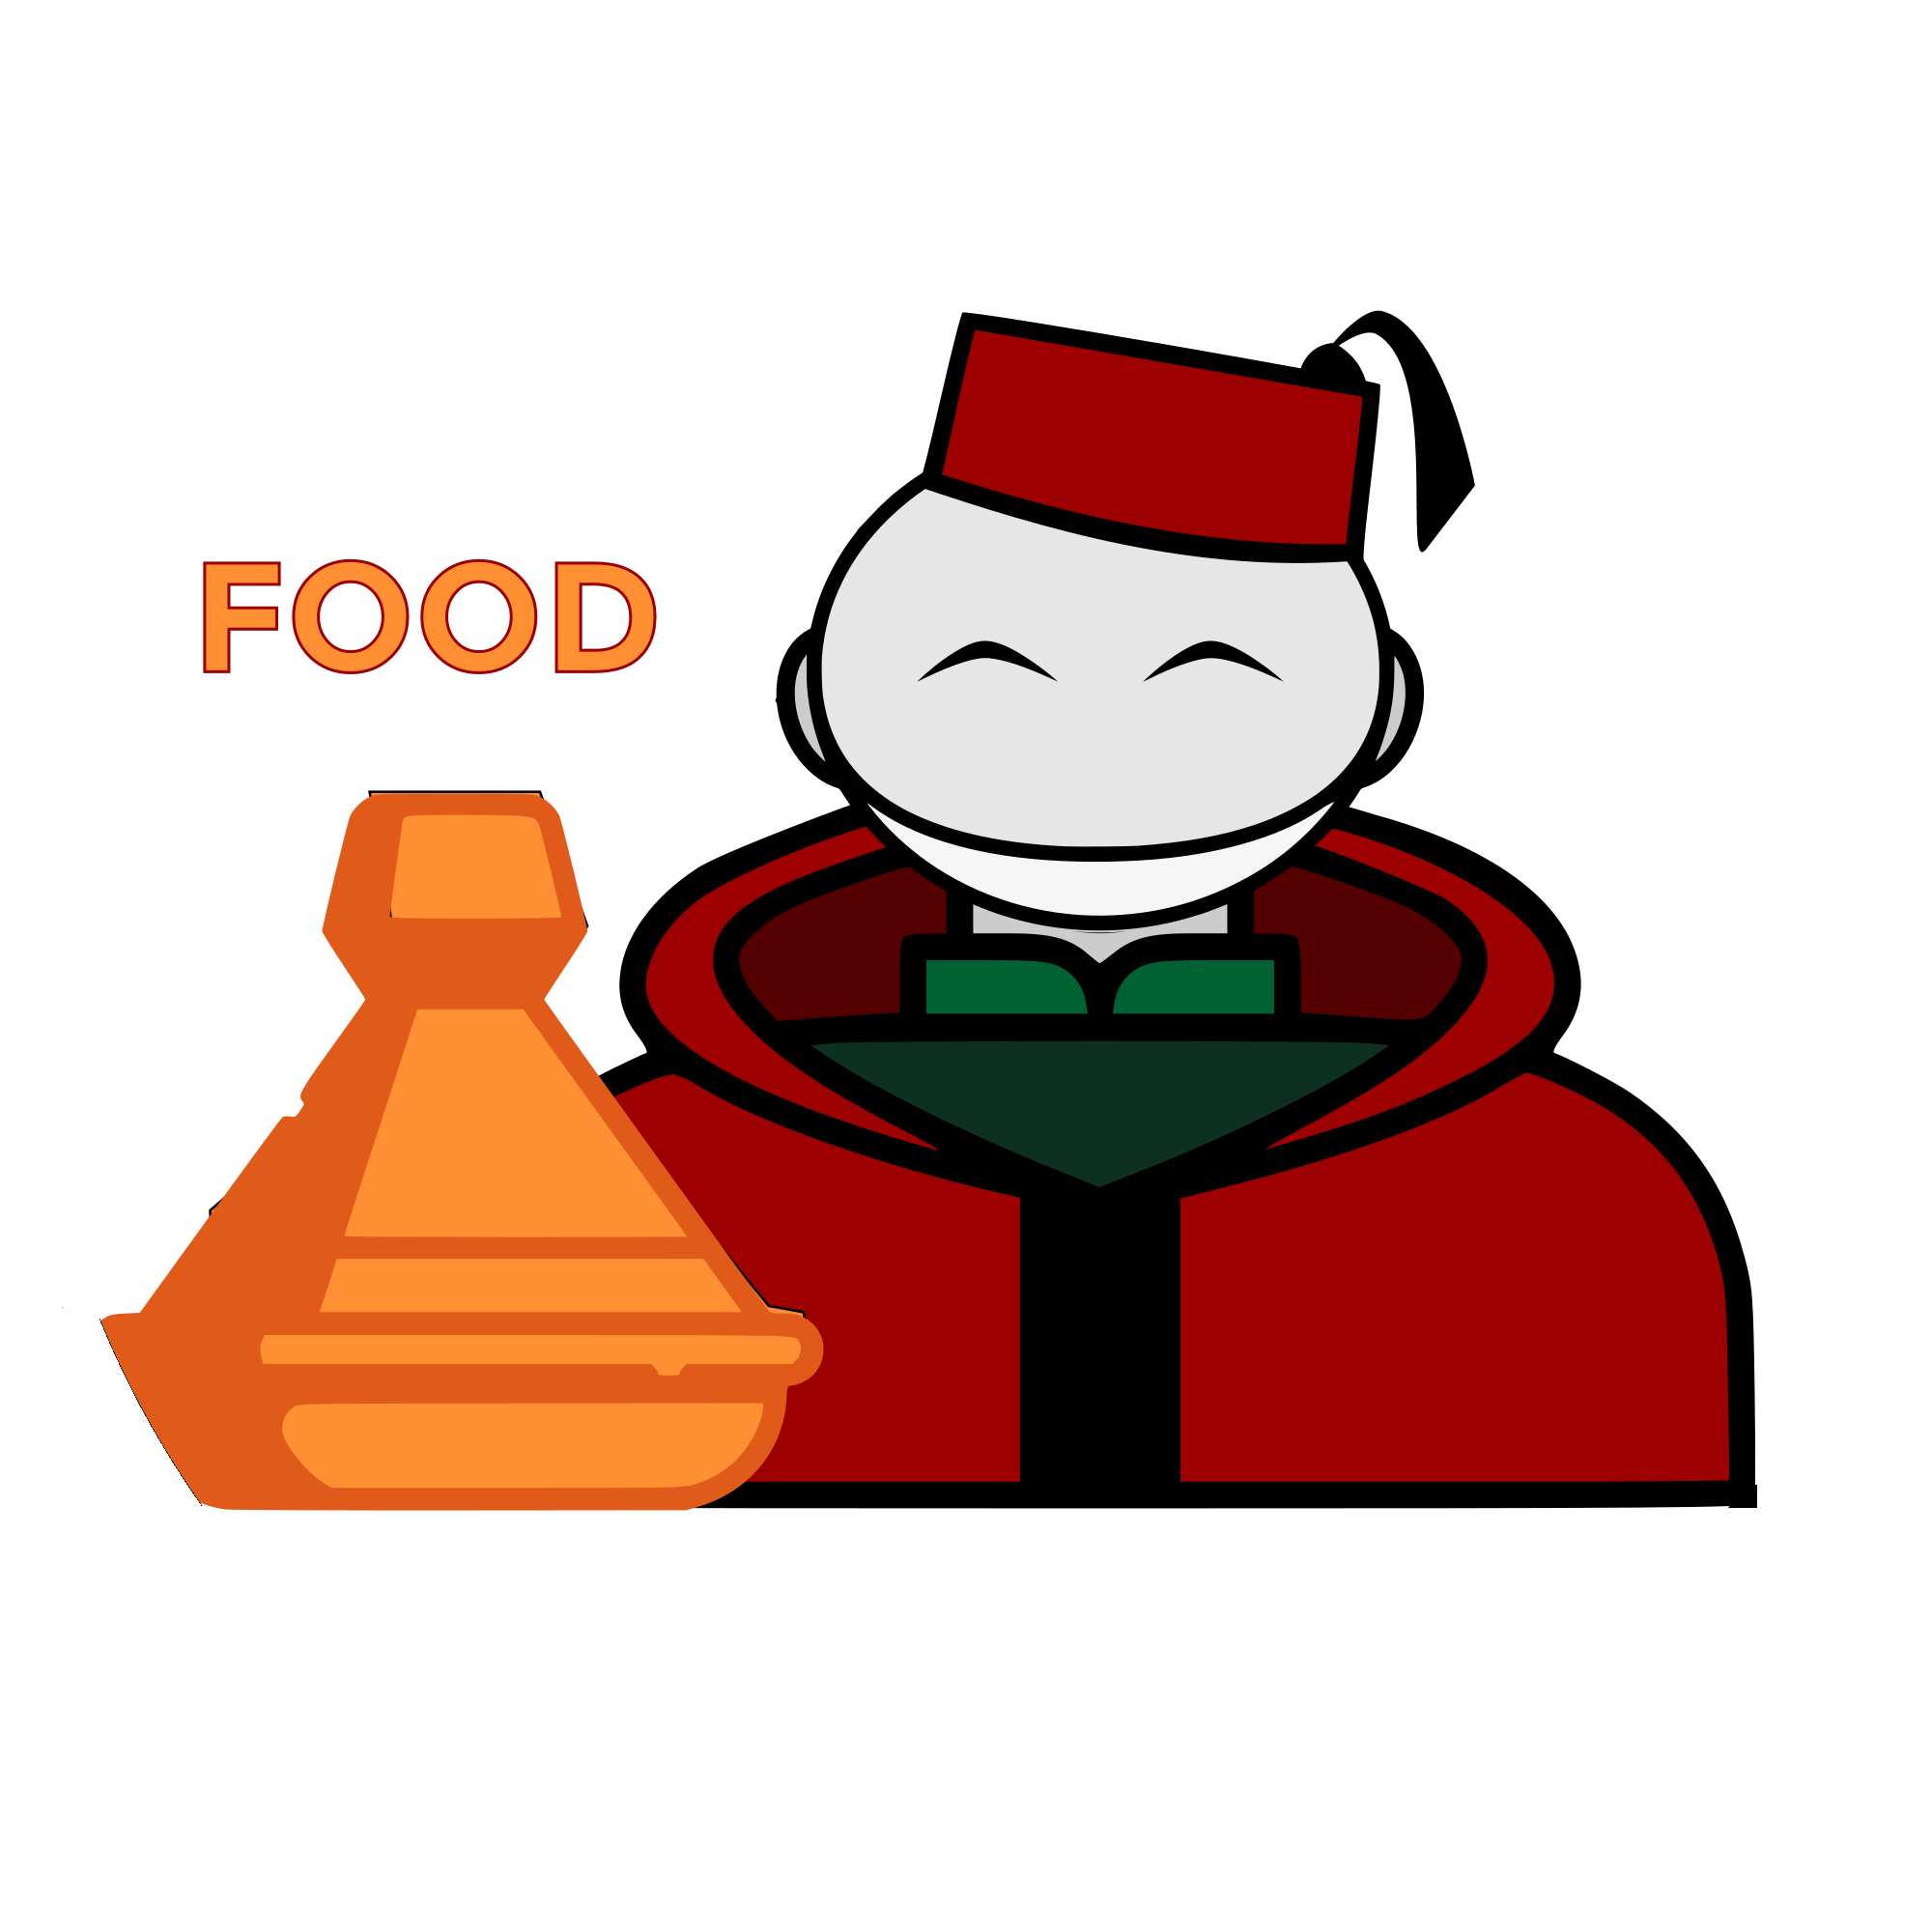
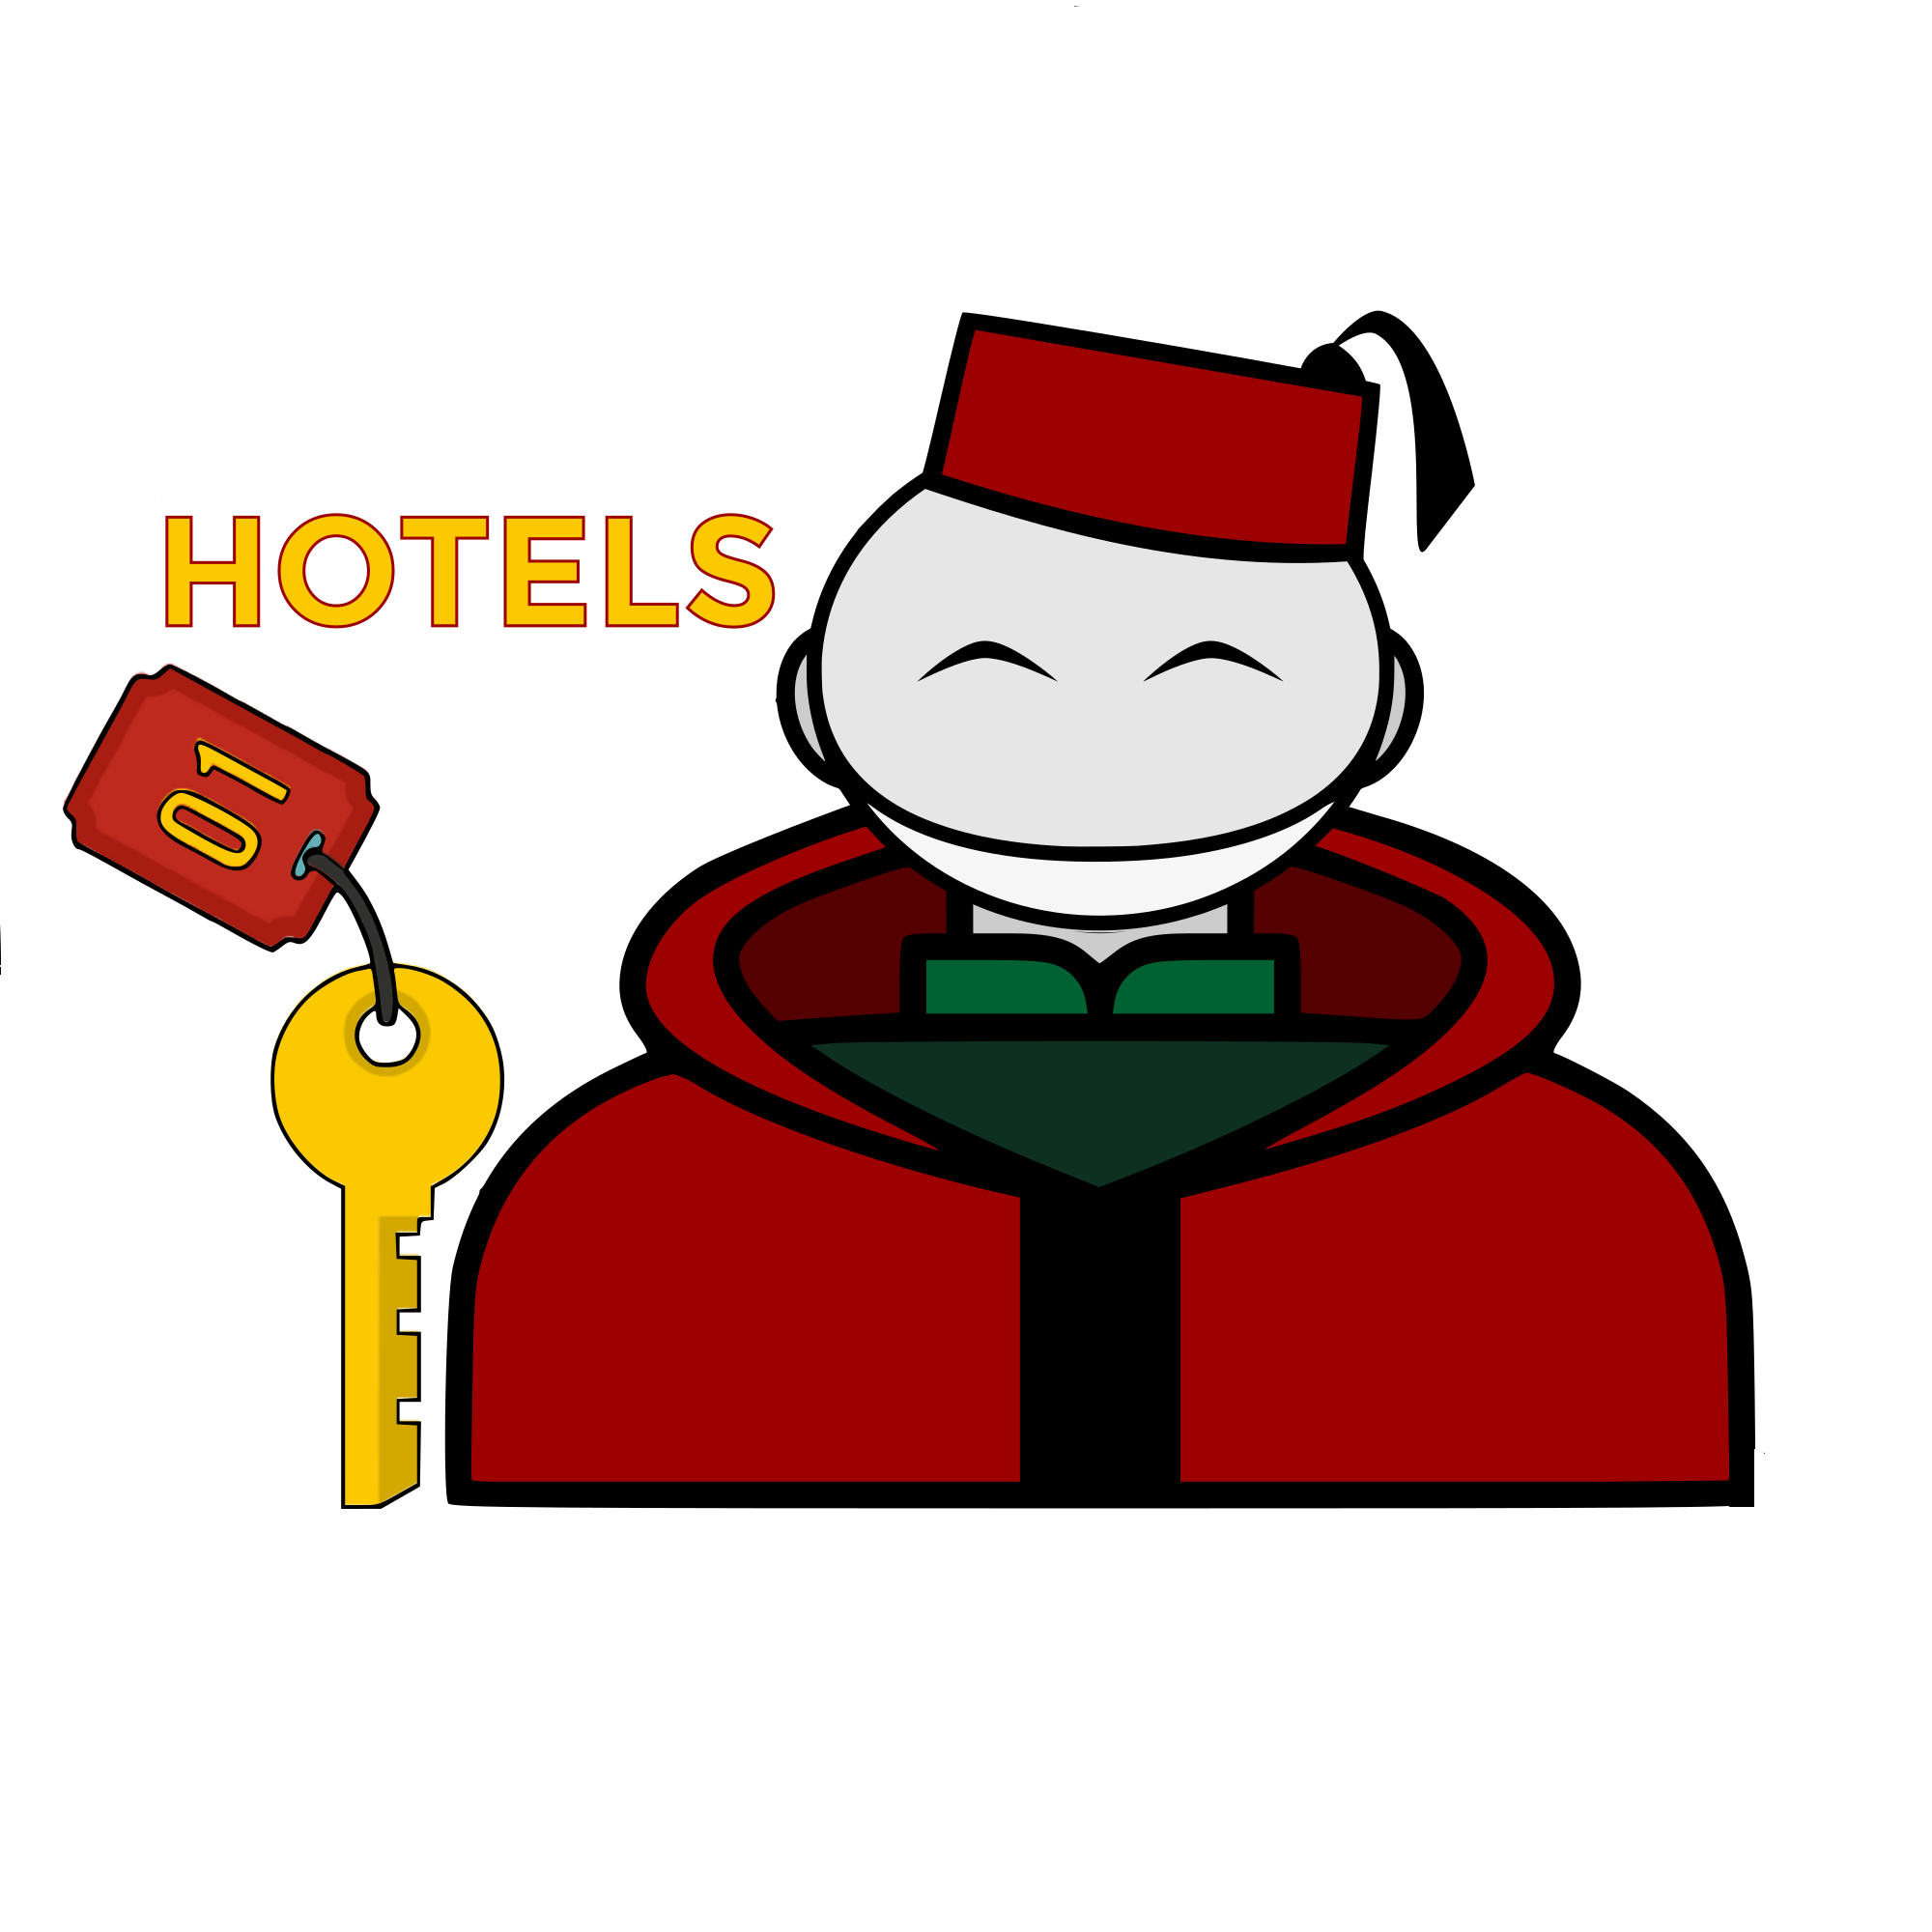

127.0.0.1 - - [26/Jul/2021 18:54:13] "GET //load/PLACES HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 18:54:32] "GET //ask/PLACES?query=bonjour HTTP/1.1" 200 -
127.0.0.1 - - [26/Jul/2021 19:04:17] "GET //load/PLACES HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:04:42] "GET //ask/PLACES?query=oui%20je%20veux%20des%20recommandations HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:04:53] "GET //ask/PLACES?query=Nord HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:05:11] "GET //ask/PLACES?query=Fès HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:06:01] "GET //ask/PLACES?query=quelle%20sont%20les%20activités%20à%20Fès HTTP/1.1" 200 -
127.0.0.1 - - [26/Jul/2021 19:08:53] "GET //list HTTP/1.1" 200 -






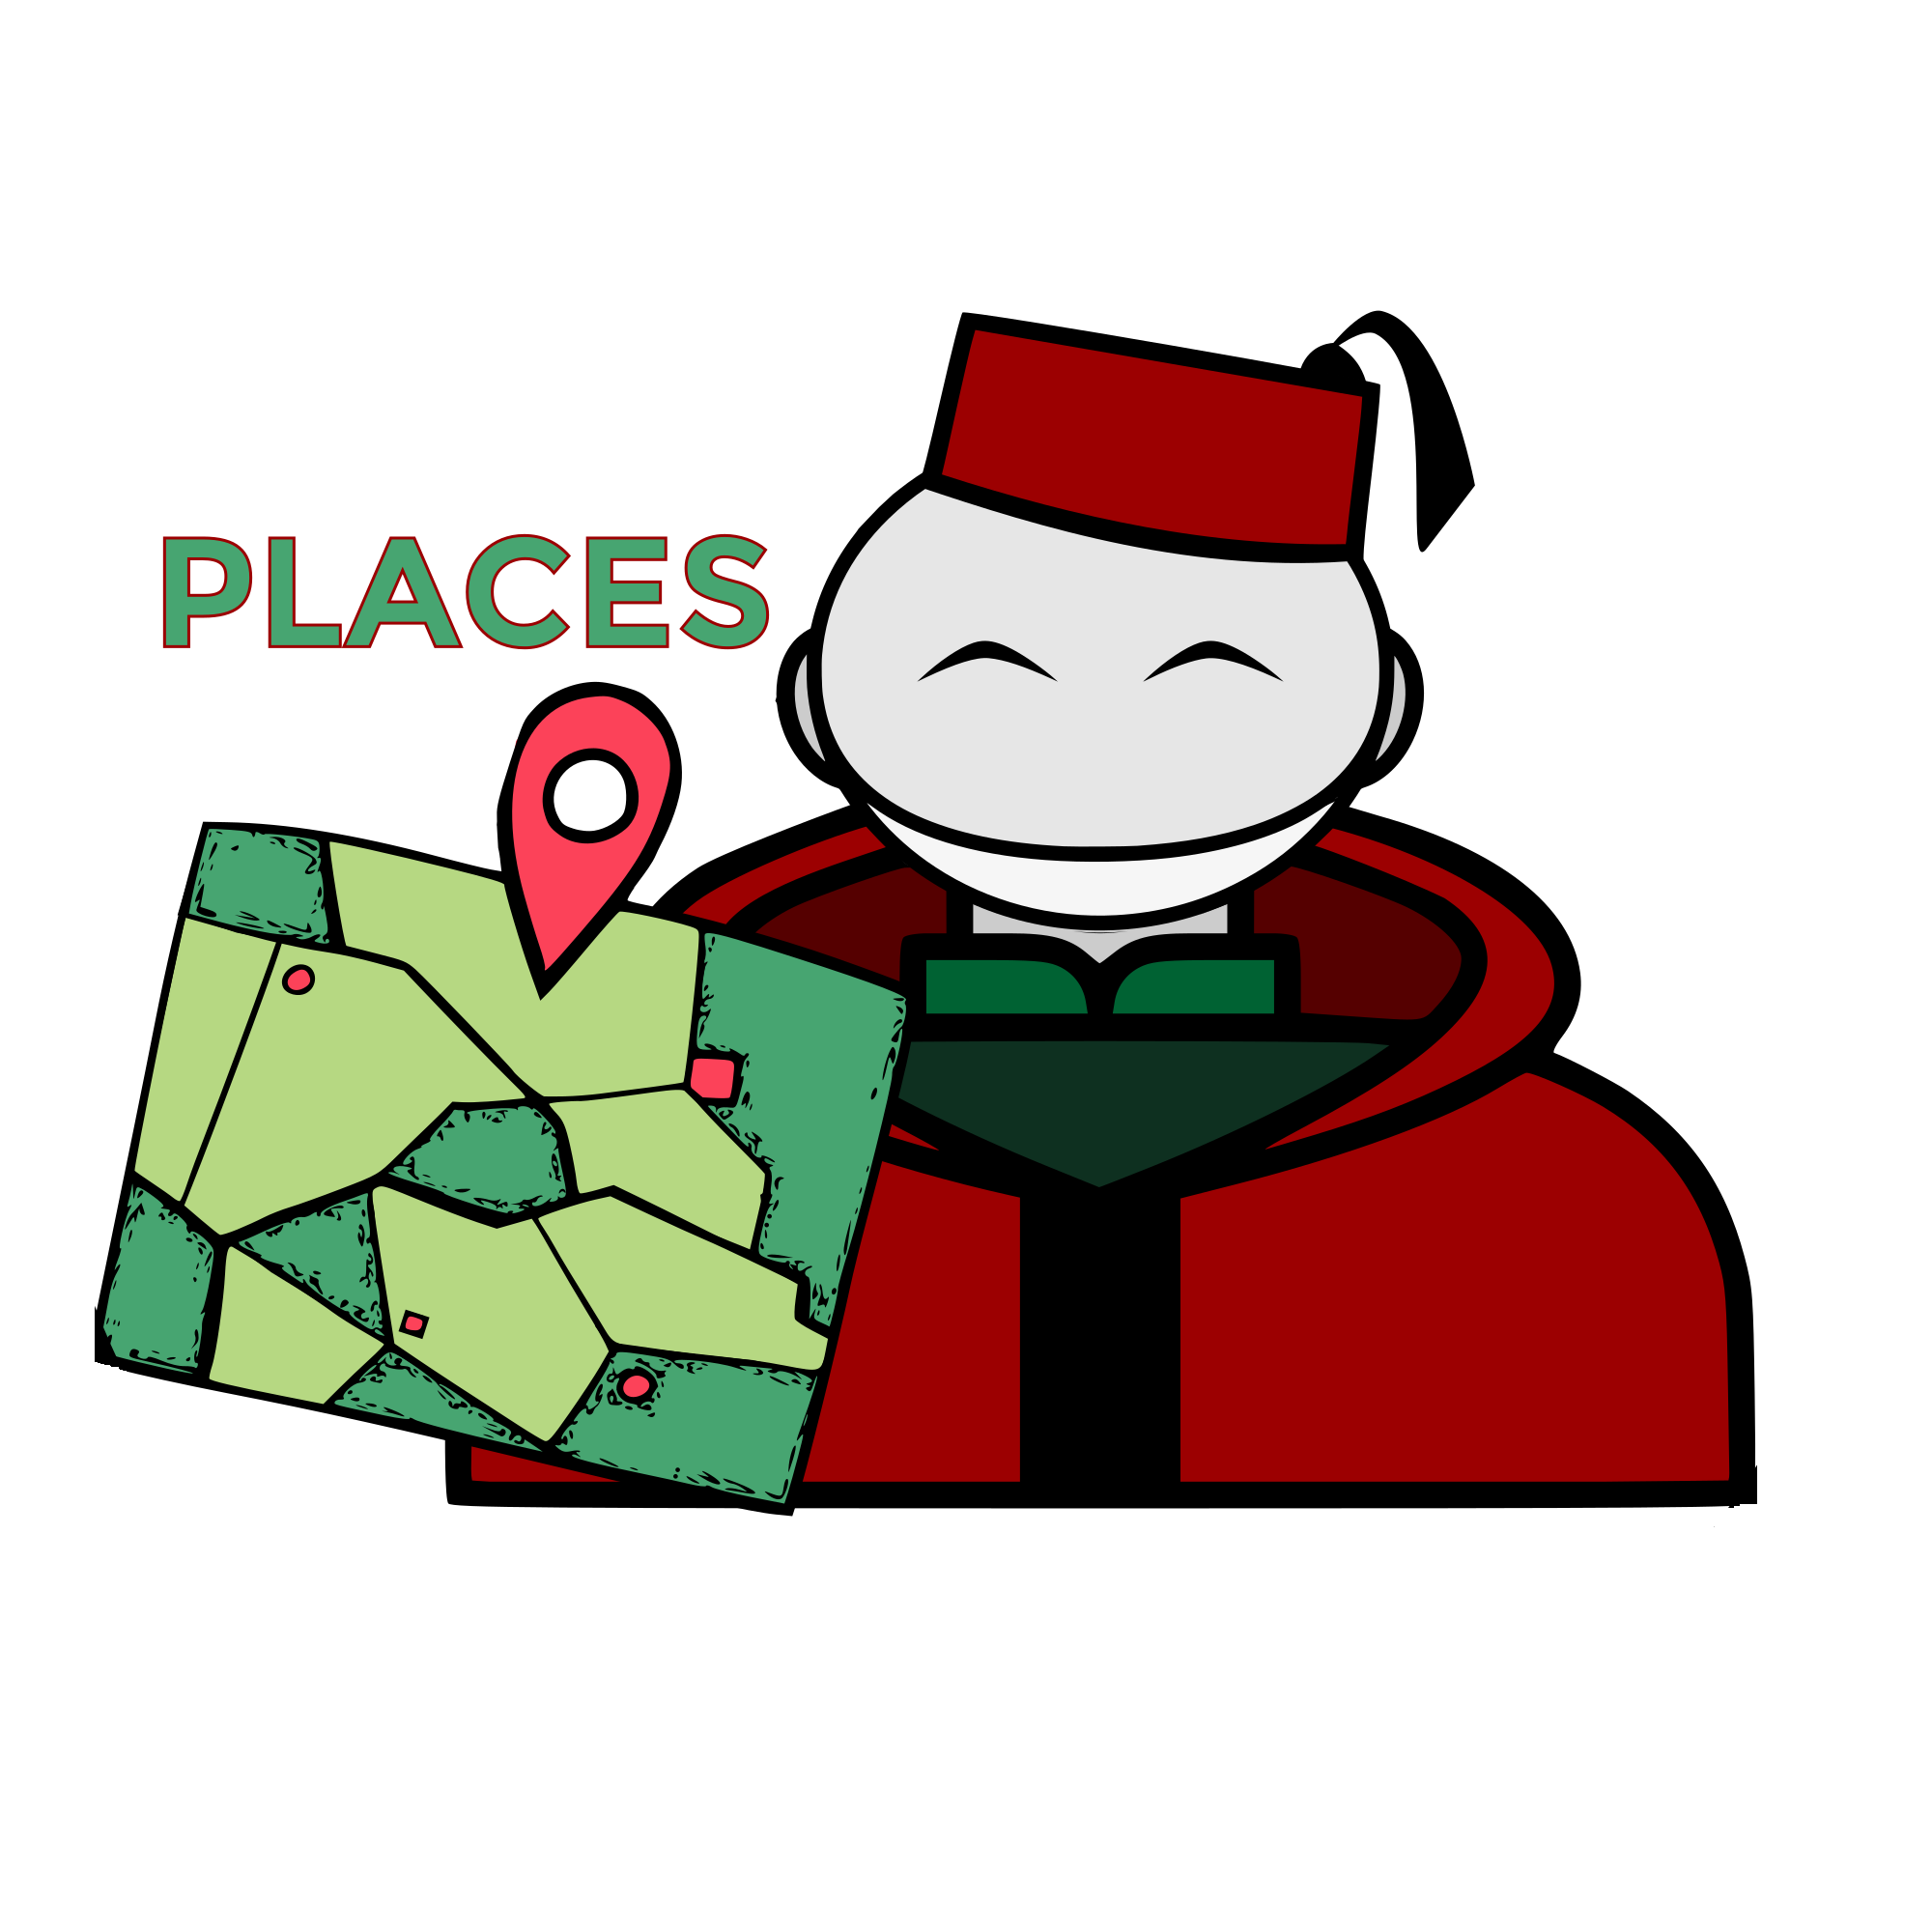
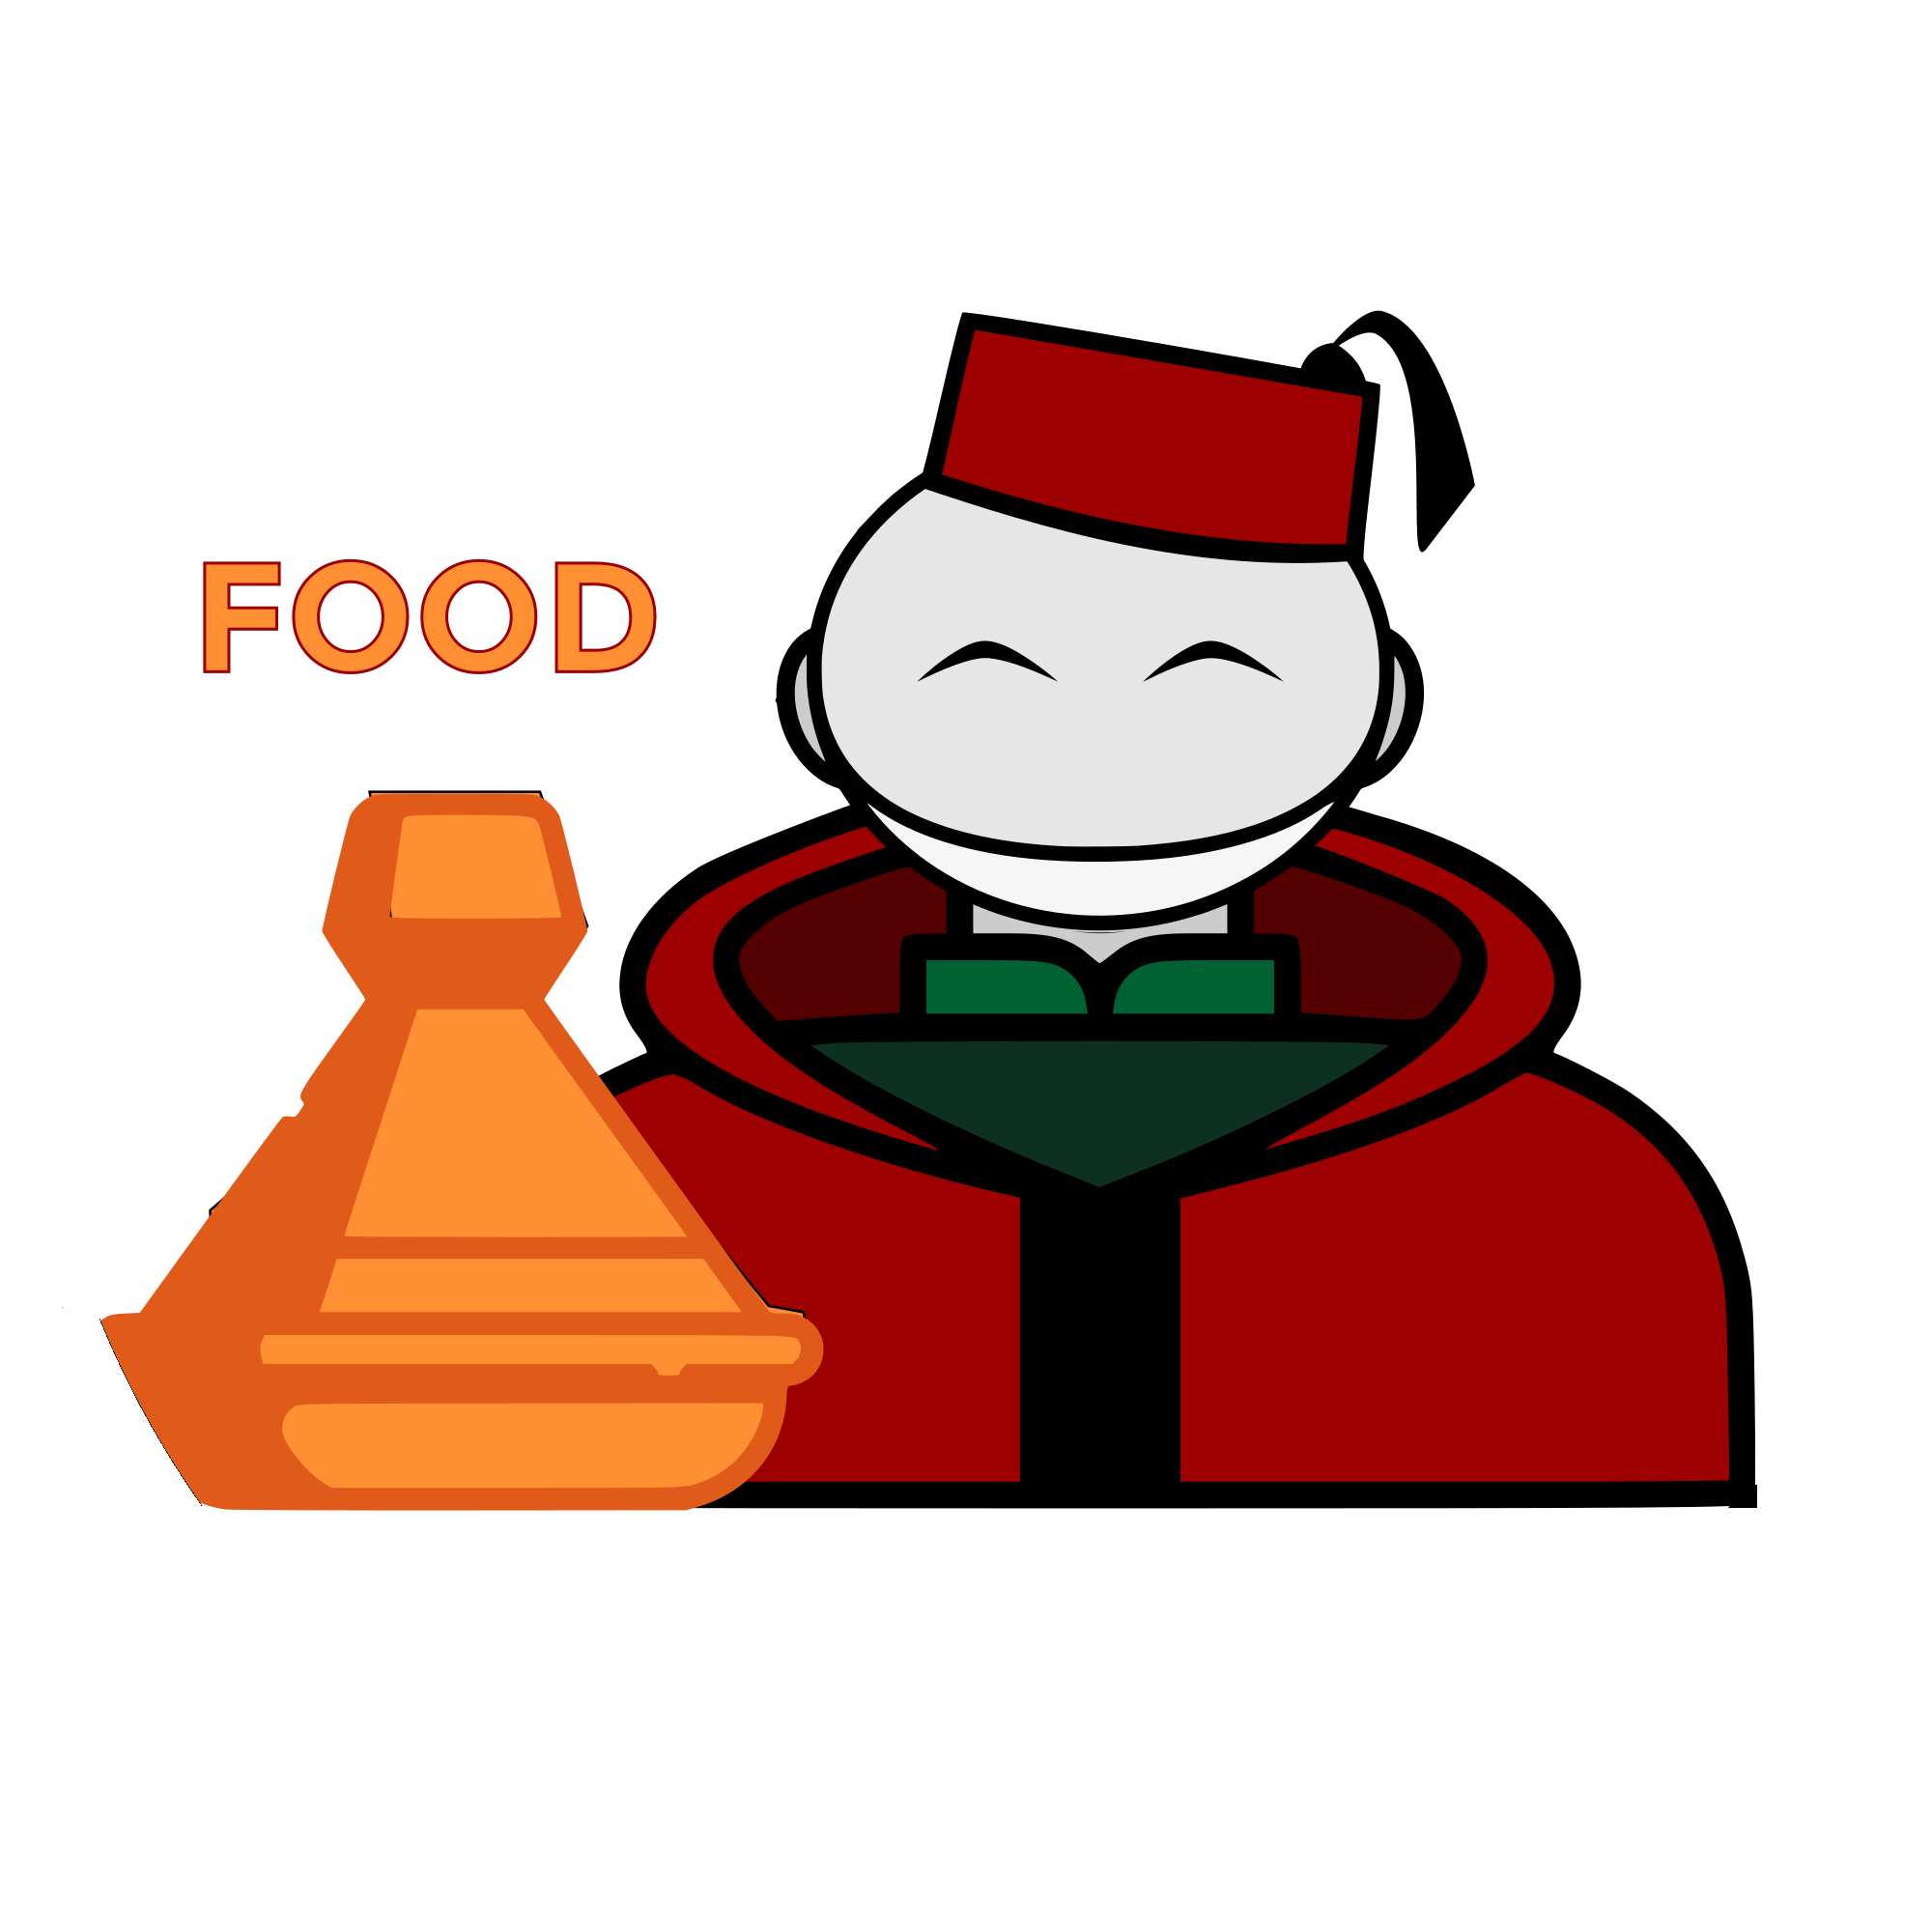
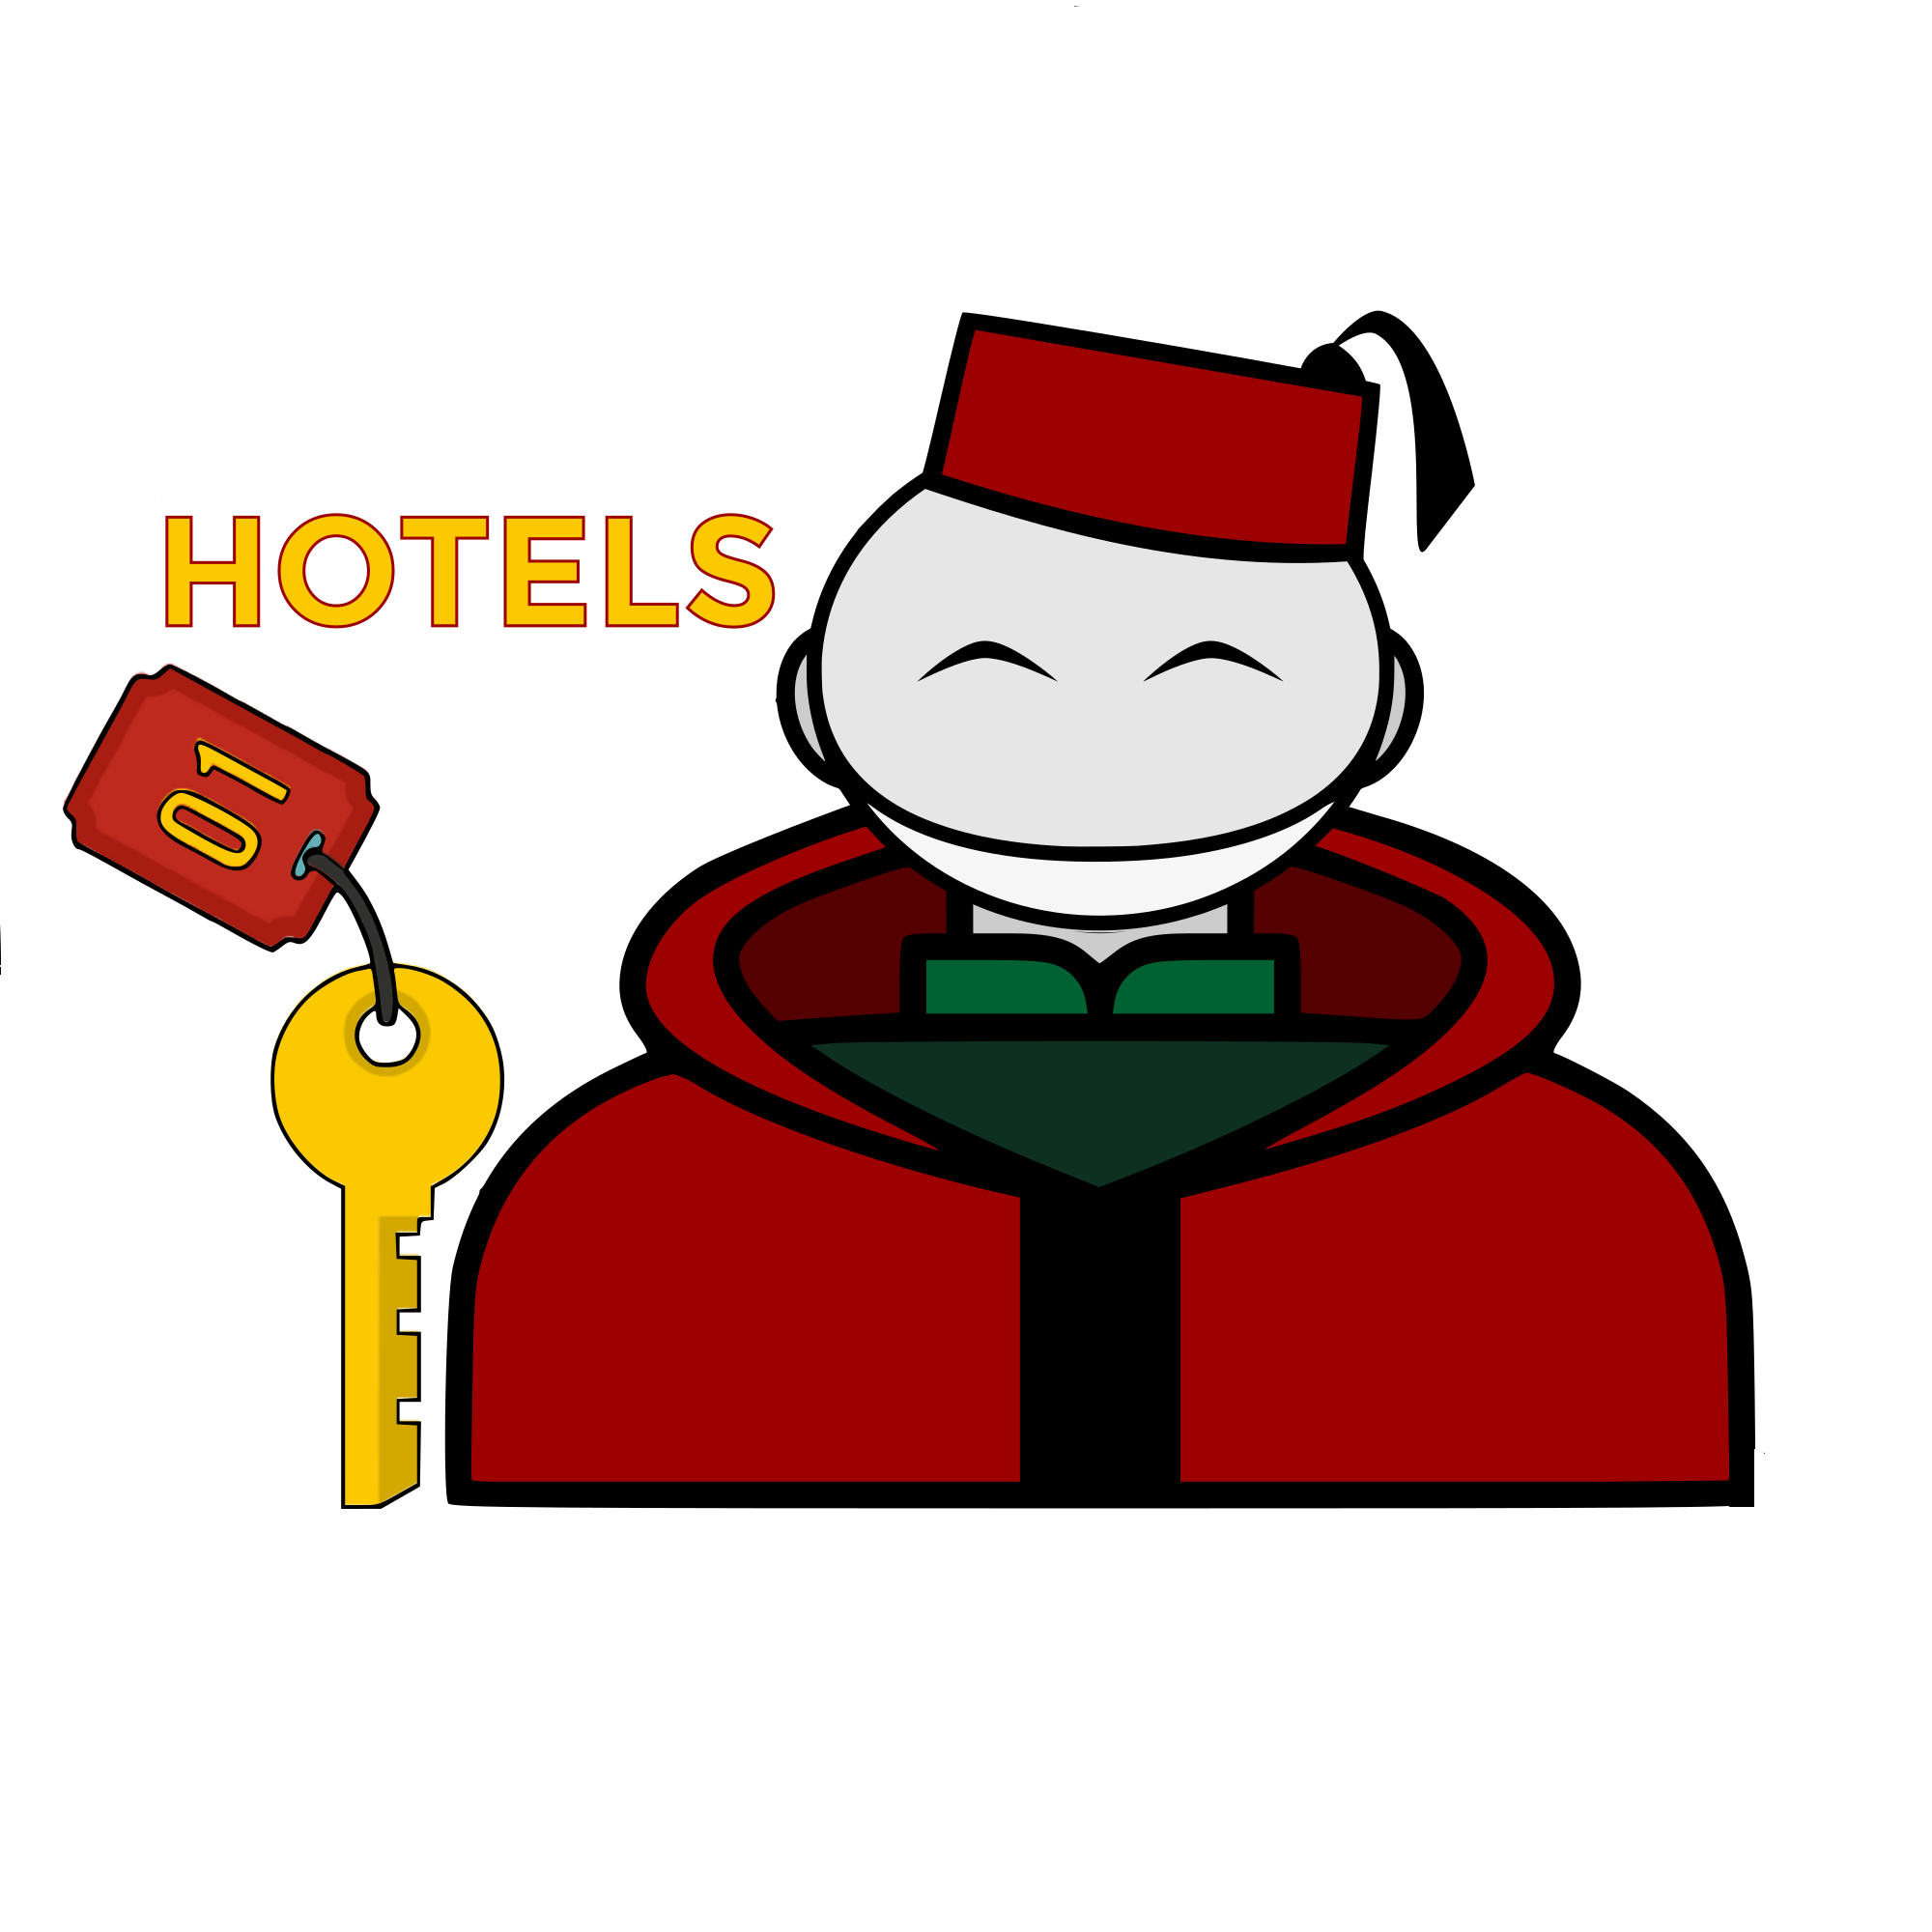

127.0.0.1 - - [26/Jul/2021 19:09:22] "GET //load/PLACES HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:09:41] "GET //ask/PLACES?query=اأهلا HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:09:49] "GET //ask/PLACES?query=أهلا HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:10:10] "GET //ask/PLACES?query=نعم%20رجاءا HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:10:21] "GET //ask/PLACES?query=الجنوب HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:10:57] "GET //ask/PLACES?query=ماذا%20يمكنني%20أن%20أفعل%20في%20أغادير HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:11:13] "GET //ask/PLACES?query=أغادير HTTP/1.1" 200 -


hello


127.0.0.1 - - [26/Jul/2021 19:12:19] "GET //ask/PLACES?query=Hola HTTP/1.1" 200 -
127.0.0.1 - - [26/Jul/2021 19:13:06] "GET //propose/PLACES?question=Hola&response=Hola,%20¿te%20gustaría%20recibir%20algunas%20sugerencias%20sobre%20ciudades?%20o%20simplemente%20puede%20preguntar%20por%20su%20lugar%20favorito HTTP/1.1" 200 -
127.0.0.1 - - [26/Jul/2021 19:14:25] "GET //propose/PLACES?question=Hola&response=Hola HTTP/1.1" 200 -
127.0.0.1 - - [26/Jul/2021 19:17:41] "GET //load/FOOD HTTP/1.1" 200 -


In [ ]:
#app.run(host='192.168.0.188',port='19000')
app.run()

In [ ]:
o={}
o["wheretogo"] = Seq2SeqChatbot("wheretogo","wheretogo.json","wheretogo.h5","wheretogo_vocab.pkl","wheretogo_classes.pkl","places.jpeg")

In [ ]:
for key in o:
            
    keys=o[key]
    print(keys.icon_path)

In [13]:
chatbot=Seq2SeqChatbot("hello","hello.json","hello.h5","hello_vocab.pkl","hello_classes.pkl")

TypeError: __init__() missing 1 required positional argument: 'icone_path'

In [219]:
chatbot.predict_intent("hello",chatbot.model)

TypeError: predict_intent() takes 2 positional arguments but 3 were given

In [ ]:
def predict_intent_oo(sentence, model):
        print("hello")
        p = self.bag_of_words(sentence, self.vocabulary, show_details=False)
        # filter out predictions by threshold
        res = model.predict(np.array([p]))[0]
        ERROR_THRESHOLD = 0.25
        results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
        # sort by probability score
        results.sort(key=lambda x: x[1], reverse=True)
        return_list = []
        for r in results:
            return_list.append({"intent": self.classes[r[0]], "probability": str(r[1])})
        
        return return_list
